<img src="https://www.kdischool.ac.kr/www/img/sub/sub_a10108010000_logo1.png" alt="Drawing
">

# **"Machine Learning: Predicting Happiness or Subjective Wellbeing (SWB) based on World Happiness Report Predictors."**

---

**By: LAY, Menghuo (ID: 202312058)**

**Date: 22, November, 2023**






## **Abstract**

> One of the ultimate goal of development is to improve the population well-being and happiness. Unlike economic indicators, this concept is very tricky to measure objectively. According to World Happiness Report 2023 findings, there are 8 factors strongly associate with subjective happiness (SWB) score. Building on this finding, this study seeks to build a machine learning algorithm to predict the quality of life based on mentioned factors as predictors such as: GDP per capita, social support, healthy life expectency, etc. First, I gather the data of many different countries from World Happiness Report 2023 (the time peroid is from 2005-2022). Second, I process the data by filling the missing value using interpolation and standardize all predictors to ensure equal contribution weigh to the mode. Third, I ran first layer regression using LASSO algorithm to perform features selection. Fourth, the selected features are fit into 2 machine learning models: (i) K-Nearest Neighbour (KNN) to predict quality of life that scale on 1-10 level; (ii) Decision Tree to predict quality of life category.



## **1. Research Motivation & Questions**

### **1.1. Research Motivation**

Over the last few years, there are increasingly more focus shifted toward happiness or subjective wellbeing of people around the world. Happiness or SWB is arguably one of the ultimate goal of development as other development indicators such as GDP and Human Development Index are intended to improve quality of life or population well being. However, it is very tricky to measure happiness level and can't be estimated like qunatitative indicators (GDP, inflation, export value, etc.). Currently, the data on happiness score are measured through survey in different countries around the world by World Happiness Report, which is costly and repetitive (surveys are conducted in many waves to record score in different years). This process is tidious and require much time to obtain the score.  

On the other hand, with the advancement of data driven machine learning approaches in various areas and topics, this can be deployed to predict happiness score in the future without spending time and financial resources to conduct the survey frequently. Annually, World Happiness Report releases a ranking of countries in term of happiness score based on various indicators, including GDP per capita, social support, life expectancy, freedom to make life choices, generosity, perceptions of corruption, positive affect, and negative affect emotion. Using these factors, I can build a predicting model using above predictors and existing survey data to fit into the model. This study will be beneficial for policymaker to have estimate beforehand and spend less time and resources to conduct the survey.

<img src="https://static.vecteezy.com/system/resources/previews/005/356/432/large_2x/silhouette-children-playing-happy-time-at-sunset-free-photo.jpg" alt="Drawing" style="width:128px;height:32px">

### **1.2. Research Questions**

This study aim to answer the **main research** questions as following:
1. What are the important features that can be used to predict happiness or SWB of countries around the world?
2. What is the accuracy for machine learning model to predict the happiness or SWB using only important features?

## **2. Data Selection**

In predicting the happiness score of different country over the years can be tricky as there are thousands of features that might influence the outcome variable. With this limitation coonsidered, this study will base on the predictors from `World Happiness Report 2023` research findings and `Our World in Data`, which has 1 label (outcome variable) and 9 predictors (independent variables) as following:

<img src="https://raw.githubusercontent.com/Menghuo-Lay/predict-happiness/4224d45466e11b083827171345a35465ed052e2b/data%20desc.png" alt="Drawing" style="width:128px;height:32px">

These predictors are regarded as the most significant independent variables in determine the happiness and SWB of people. Using these highly relevant features, the data feed into the machine algorithm will be more accurate and less affected by noises.

### **2.1. Merge the dataset**

Above dataset are available from 2 sources here.
- `whr`: https://happiness-report.s3.amazonaws.com/2023/DataForTable2.1WHR2023.xls
- `age`: https://ourworldindata.org/grapher/median-age

In this section, both dataset are merged together based on country and year as unit of analysis. `whr` is considered as the main dataset for merging reference as it contains the label (y). The merging was done using `pandas` library in Jupyter Notebook. Below is the full code for recreational purposes.

**NOTE:**
For readability, all libraries and functions used in this paper will be stored here.

In [297]:
# @title **Step 1: Libraries and Functions** { display-mode: "form" }
# install new library
%%capture
!pip install pycountry_convert

# library for data manipulation
import pandas as pd
import numpy as np
import pycountry_convert as pc
import math

# library for visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import warnings
from sklearn.tree import DecisionTreeClassifier
import pydotplus
from IPython.display import Image
import plotly.express as px

# library for machine learning
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree
import pickle

# library for prediction score metric
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix

# functions for adding continent to the dataset
def convert(row):
    cn_code = pc.country_name_to_country_alpha2(row.Country, cn_name_format = 'Default')
    conti_code = pc.country_alpha2_to_continent_code(cn_code)
    return conti_code

# function to make prediction using machine learning model
def make_prediction(model, features):
    label = model.predict([features])[0]
    return label

In [298]:
# @title **Step 2: Import the dataset** { display-mode: "form" }
# import the raw dataset
whr = pd.read_csv("https://raw.githubusercontent.com/Menghuo-Lay/predict-happiness/main/DataForTable2.1WHR2023.csv")
age = pd.read_csv("https://raw.githubusercontent.com/Menghuo-Lay/predict-happiness/main/median-age.csv")

In [299]:
# @title **Step 3: Inspect `whr` structure** { display-mode: "form" }
# rename the columns' name as appropriate
whr_final = whr.rename(
    columns = {'year': 'Year',
               'Country name': 'Country'}
)

# recheck the whr dataset
print(whr_final.info())
whr_final.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2199 entries, 0 to 2198
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country                           2199 non-null   object 
 1   Year                              2199 non-null   int64  
 2   Life Ladder                       2199 non-null   float64
 3   Log GDP per capita                2179 non-null   float64
 4   Social support                    2186 non-null   float64
 5   Healthy life expectancy at birth  2145 non-null   float64
 6   Freedom to make life choices      2166 non-null   float64
 7   Generosity                        2126 non-null   float64
 8   Perceptions of corruption         2083 non-null   float64
 9   Positive affect                   2175 non-null   float64
 10  Negative affect                   2183 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 189.1+ KB
None


,Country,Year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.5,0.718,0.168,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.8,0.679,0.191,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.1,0.600,0.121,0.707,0.517,0.275


In [300]:
# @title **Step 4: Inspect `age` structure** { display-mode: "form" }
# since there are 2 columns for median age (to specify source)
# let's create new columns which is mean of the 2 columns
age['Median age'] = np.nanmean(
    age[['Median age - Sex: all - Age: all - Variant: estimates',
         'Median age - Sex: all - Age: all - Variant: medium']],
    axis = 1
)

# drop the 2 original columns that's no longer needed
age_drop = age.drop(
    age[['Median age - Sex: all - Age: all - Variant: estimates',
         'Median age - Sex: all - Age: all - Variant: medium']],
    axis = 1
)

# rename the columns' name as appropriate
age_final = age_drop.rename(
    columns = {'Entity':'Country'}
)

# recheck the age dataset
print(age_final.info())
age_final.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38505 entries, 0 to 38504
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Country     38505 non-null  object 
 1   Code        35938 non-null  object 
 2   Year        38505 non-null  int64  
 3   Median age  38505 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.2+ MB
None


,Country,Code,Year,Median age
0,Afghanistan,AFG,1950,18.4
1,Afghanistan,AFG,1951,18.4
2,Afghanistan,AFG,1952,18.4


**Step 3:** Merge the data using `pd.merge()`

In [301]:
# @title **Step 5: Merge the data** { display-mode: "form" }
# merge the data base on country and year
merge_df = pd.merge(
    whr_final,
    age_final,
    how = 'left',
    on = ['Country', 'Year']
)

**Step 4:** Add continent code for more visualize options

In [302]:
# @title **Step 6: Add continent** { display-mode: "form" }
# rename some countries to ISO recognized
merge_df['Country'] = merge_df['Country'].replace(
    {'Turkiye': 'Turkey',
     'Congo (Brazzaville)': 'Congo',
     'Congo (Kinshasa)': 'Congo',
     'Hong Kong S.A.R. of China': 'Hong Kong',
     'Kosovo': 'Serbia',
     'Somaliland region': 'Somaliland',
     'State of Palestine': 'Palestine',
     'Taiwan Province of China': 'Taiwan'}
)

# apply continent assignment function
merge_df['Continent'] = merge_df.apply(convert, axis = 1)

# rename the continent code to full name
continent_list = {
    'AS': 'Asia',
    'SA': 'South America',
    'OC': 'Oceania',
    'EU': 'Europe',
    'NA': 'North America',
    'AF': 'Africa'
}

# map the continent column to the rest of the dataset
merge_df['Continent'] = merge_df['Continent'].map(continent_list)

# check if the continent matched
print(f'Variables:{merge_df.shape[1]}, Observations:{merge_df.shape[0]}')
merge_df.head(3)

Variables:14, Observations:2199


,Country,Year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Code,Median age,Continent
0,Afghanistan,2008,3.724,7.350,0.451,50.5,0.718,0.168,0.882,0.414,0.258,AFG,14.0,Asia
1,Afghanistan,2009,4.402,7.509,0.552,50.8,0.679,0.191,0.850,0.481,0.237,AFG,14.3,Asia
2,Afghanistan,2010,4.758,7.614,0.539,51.1,0.600,0.121,0.707,0.517,0.275,AFG,14.4,Asia


## **3. Data Processing & Description**

### **3.1. Data Structure and Biases**

In this section, I run descriptive statistics to find data biases, variances, outliers, and overall nature of each variable. For example, life expectancy should not contain any negative values.

In [303]:
# @title **Step 1: Descriptive statistics** { display-mode: "form" }
# drop unit of analysis from dataframe
desc_df = merge_df.drop(
    columns = ['Country',
               'Code',
               'Year',
               'Continent']
)

# descriptive statistics summary
data_types = desc_df.dtypes.unique()
desc_stats = desc_df.describe()
skew_values = desc_df.skew()
desc_stats.loc['skew'] = skew_values

# print the result
print(f'Data types:{str(data_types)}.')
round(desc_stats.T, 3)

Data types:[dtype('float64')].


,count,mean,std,min,25%,50%,75%,max,skew
Life Ladder,2199.0,5.479,1.126,1.281,4.647,5.432,6.310,8.019,-0.018
Log GDP per capita,2179.0,9.390,1.153,5.527,8.500,9.499,10.374,11.664,-0.335
Social support,2186.0,0.811,0.121,0.228,0.747,0.836,0.905,0.987,-1.119
Healthy life expectancy at birth,2145.0,63.295,6.901,6.720,59.120,65.050,68.500,74.475,-1.145
Freedom to make life choices,2166.0,0.748,0.140,0.258,0.656,0.770,0.859,0.985,-0.671
Generosity,2126.0,0.000,0.161,-0.338,-0.112,-0.023,0.092,0.703,0.777
Perceptions of corruption,2083.0,0.745,0.186,0.035,0.688,0.800,0.869,0.983,-1.490
Positive affect,2175.0,0.652,0.106,0.179,0.572,0.663,0.738,0.884,-0.436
Negative affect,2183.0,0.271,0.087,0.083,0.208,0.261,0.323,0.705,0.731
Median age,2104.0,28.996,9.111,13.800,21.000,28.200,37.900,48.700,0.076


Base on the tables above, the unit of analysis is at country and year level. The label (y) and 9 features (X) are measured in continuous values with positive mean, min, and max values; execpt the feature `Generosity`. These continuous variables are fit for various machine learning approaches that satisfied the research motivation and questions. In machine learning principle, the main interest remains on the label (y) rather than the feature (X). Hence, in selecting machine learning approach, we will need to further study the nature of label (y).

However, there are 3 potential biases when fitting unclean data to the algorithm, namely:
1. Missingness: based off the full observations of 2,199 from `Life Ladder`, there are some missing data in all features (see above table in `count` column). There are 2 main considerations for this potential bias, the pattern of missingness is either by random or systemetic. Details discussion and approach to solve this is in **Missingness** section.

2. Inequal Scaling: machine learning algorithms to be deployed in this study are somewhat sensitive to different scaling level. For example, `Median age` and `Healthy life expectancy at birth` are scale in high value compare to the rest. Without standardizing the scale for all features, this could lead to model contribution bias for some model. Deatils on this is in **Outliers and Scale** section.

3. Outliers: base off how far spread `min` and `max` values are from the `mean` value; and looking at the `skewness` value, outliers can be identified. For example, feature: `Perceptions of corruption`, has relatively high negative `skew` with very low `min` value, suggesting some outliers appear at the left tail of the distribution. Details graph and analysis on this bias is in **Outliers and Scale** section.

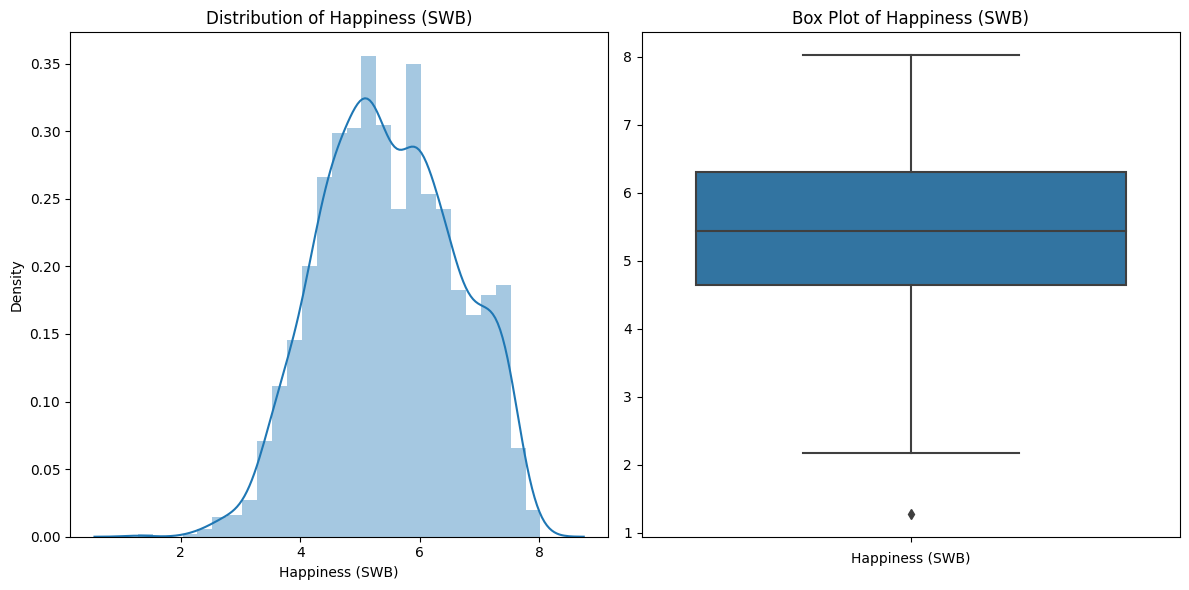

In [304]:
# @title **Step 2: Plot the distribution** { display-mode: "form" }
# create a figure with two subplots
warnings.filterwarnings("ignore")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))

# density plot of the label (y)
label = merge_df['Life Ladder']

sns.distplot(label, ax = ax1)
ax1.set_title('Distribution of Happiness (SWB)')
ax1.set_xlabel('Happiness (SWB)')

# box plot for some of the features (X)
sns.boxplot(label, ax = ax2)
ax2.set_title('Box Plot of Happiness (SWB)')
ax2.set_xlabel('Happiness (SWB)')
ax2.set_xticklabels([])

# customize and plot
plt.tight_layout()
plt.show()

In machine learning, we are more interested in the label (y) rather than the features (X). This is because we are not interested in studying the association or causality between X and y, but rather how can we accurately predict label (y) from pattern seen in X. Overall, the label (y) distribution seem fine with a few outlier on the left tail. This outlier will be considered later when fitting the dataset to train the model.

### **3.2. Data Missingness**

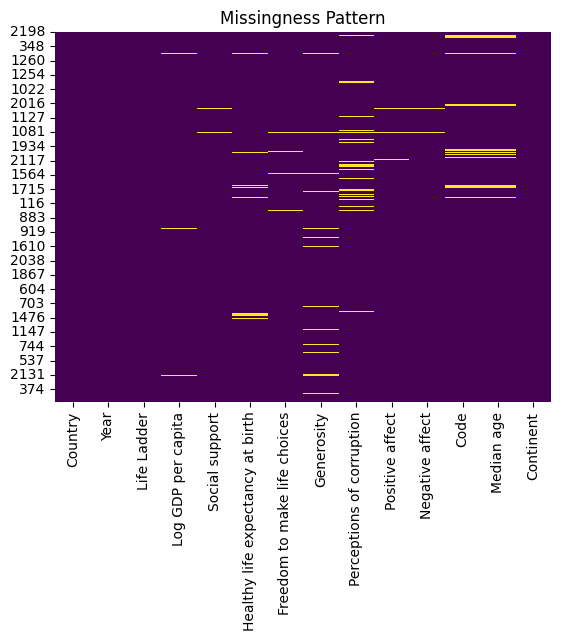

In [305]:
# @title **Step 1: Plot the missing data heatmap** { display-mode: "form" }
# sort to continents to see missing pattern in different region
sort_df = merge_df.sort_values(
    by = 'Continent',
    ascending = True
)

# plot the heatmap of missing data
sns.heatmap(
    sort_df.isnull(),
    cbar = False,
    cmap = 'viridis'
)

plt.title('Missingness Pattern')
plt.show()

The heatmap above show that the missing seem to be distributed fairly more at the top which are mostly `Africa` and `Asia` countries. While there seem to be less missing among the lower observation which are `North and South America`. Clearly, the missingness pattern is not random and can't be dropped without affecting the model performance later. To deal with this, we can look at the correlation between variables and deplote interploate technique to fill missing data based off the highly correlated variables.

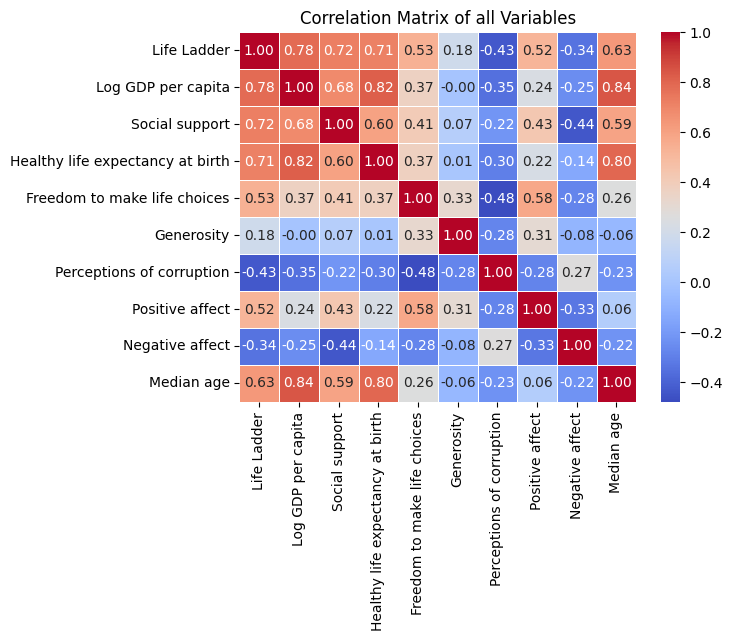

In [306]:
# @title **Step 2: Build correlation matrix** { display-mode: "form" }
# using peasrson correlation
correlation = desc_df.corr(method = 'pearson')

# plot the correlation heatmap
sns.heatmap(
    correlation,
    cmap = "coolwarm",
    annot = True,
    fmt = "0.2f",
    linewidths = 0.5
)

plt.title('Correlation Matrix of all Variables')
plt.show()

Based on the heatmap above, with the exception of `Generosity`, most features (X) are highly correlated with the label (y). For instance, features: `Log GDP per capita`, `Social Support`, and `Healthy life expectancy` are highly correlated with `Life Ladder`, with correlation coefficient $r > 0.7$. While, `Freedom to make choices`, `Median age`, and so on are moderately correlated at $0.3 < r < 0.7$. In term of cross features, there are lesser correlated strength, however, most variables are fairly correlated. Hence, linear interpolation technique will be employed to fill in the missing value of the dataset.

In [307]:
# @title **Step 3: Interpolate the missingness** { display-mode: "form" }
# interpolate the missing data using linear method
fill_df = merge_df.interpolate(method = 'linear', axis = 0)

# check if the NaN are filled
desc_fill = fill_df.describe()
min_observation = int(desc_fill.iloc[0].min())

# check mean differences filled vs initial
initial_mean = desc_stats.iloc[1,:]
fill_mean = desc_fill.iloc[1, 1:]
mean_dif = fill_mean - initial_mean

# print the result
print(f'The minimum observations among all variables: {min_observation}.')
pd.DataFrame(mean_dif).T

The minimum observations among all variables: 2199.


,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Median age
mean,0.0,-0.003448,0.000244,-0.025333,0.000238,0.000389,-0.003622,-0.000395,0.000253,-0.141082


As table above suggest, the mean differences between initial dataset and filled dataset are not significantly different, hence, I will not perform t-test to seek the statistical significant of the differences since the value is neglegible. From here, I will proceed with the filled dataset for pattern analysis and model training.

### **3.3. Date Outliers and Scaling**

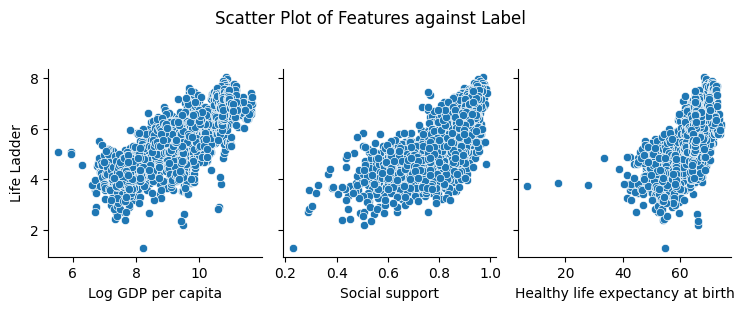

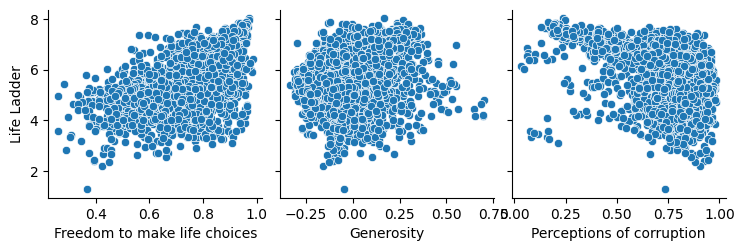

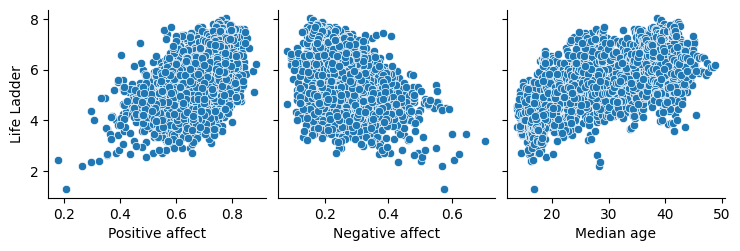

In [308]:
# @title **Step 1: Scatter plot** { display-mode: "form" }
# establish feature variables
features1 = [
    'Log GDP per capita',
    'Social support',
    'Healthy life expectancy at birth'
]

features2 = [
    'Freedom to make life choices',
    'Generosity',
    'Perceptions of corruption'
]

features3 = [
    'Positive affect',
    'Negative affect',
    'Median age'
]

# establish the label variable
label = ['Life Ladder']

# create the scatter plot to check relation and outliers
warnings.filterwarnings("ignore")

# there are 9 pairs of scatter plot (3x3 layout)
# 1st row layout
sns.pairplot(
    fill_df,
    x_vars = features1,
    y_vars = label,
    kind = 'scatter',
    diag_kws = {'edgecolor': 'none'}
)

plt.suptitle("Scatter Plot of Features against Label", y=1.2)

# 2nd row layout
sns.pairplot(
    fill_df,
    x_vars = features2,
    y_vars = label,
    kind = 'scatter'
)

# 3rd row layout
sns.pairplot(
    fill_df,
    x_vars = features3,
    y_vars = label,
    kind = 'scatter'
)

# show all plots
plt.show()

The scatterplot above shows that there aren't much outliers in the dataset when pairing each feature with the label. In this case, I will assume that outliers doesn't impact much on the model performance later and only consider the scaling differences during model hyper-training.

### **3.4. Data Limitations**

In [309]:
# @title **Step 1: Calculate full data** { display-mode: "form" }
# number of unqiue countries
num_country = len(merge_df['Country'].unique())

# number of unique years
num_year = len(merge_df['Year'].unique())

# print result
print(f'Full dataset: {num_country * num_year} observations from {num_country} countries over {num_year} years')
print(f'Collected dataset: {len(merge_df)} observations')

Full dataset: 2934 observations from 163 countries over 18 years
Collected dataset: 2199 observations


As the number above suggested, the full dataset should be 2916 observations, while the accessible data is only up to 2199 observations. Moreover, the figures are measured at country level annually instead of a more micro level such as by city/indivdual monthly. This mean the predicting model, will only be useful to anticipate the country level trend once a year, which can be too long for policy making decision. Therefore, further researches can focus more on in-depth level dataset, which has more observations (higher data availability leads to higher model accuracy).  

## **4. Analysis & Visualization**

### **4.1. Empirical patterns and associations**

In [310]:
# @title **Graph 1: World Happiness Map** { display-mode: "form" }
# sort the data by year ascendingly
year_df = fill_df.sort_values(by = 'Year')

# plot parameter
fig = px.choropleth(
    year_df,
    locations = 'Code',
    color = 'Life Ladder',
    hover_name = 'Country',
    animation_frame = 'Year',
    color_continuous_scale = px.colors.sequential.YlGnBu
)

# customization and plot
fig.update_layout(
    title_text = 'Happiness (SWB) by Country over the years',
    geo = dict(
        showcoastlines = True,
        coastlinecolor = "Black"
    ),
    coloraxis_colorbar = dict(
        title = 'Happiness (SWB) score'),
    height = 700,
    width = 1100
    )

fig.show()

Click play button of to see the pattern of happiness over the world through out 2005 to 2022, the bolder the blue color the happier are the area. As we can see from the map infographic, Australia, North America and Europe always apprear in blue, indicating that people these regions are relatively happier than people in the region such as Africa and Asia. This clearly shows that happiness (SWB) does related to the country/region they are in. Notice by the color scaling on the right side, the maximum happiness (SWB) seems to decrease as the year progresses, indicating that people time might have negatively associate relationship with the happiness (SWB). Let's graph the happiness movement overtime to test this pattern further.

In [311]:
# @title **Graph 2: Happiness Movement** { display-mode: "form" }
# calculate the average happiness score by each continent
conti_df = year_df.groupby(['Continent', 'Year'])['Life Ladder'].mean().reset_index()

# line plot for by year trend
fig = px.line(
    conti_df,
    x = 'Year',
    y = 'Life Ladder',
    color = 'Continent',
    title = 'Interactive Line Plot of Happiness Score by Continent'
)

# customize and plot
fig.update_layout(
    xaxis_title = 'Year',
    yaxis_title = 'Happiness Score',
    legend_title = 'Continent',
    plot_bgcolor = '#f5f5f5',
    xaxis = dict(linecolor = 'black'),
    yaxis = dict(linecolor = 'black'),
    height = 700,
    width = 1100
)

fig.show()

The graph above suggest that all continents have relatively high happiness (SWB) level in 2005 and experienced a huge drop in 2006 before starting to recover fluctuately throughout the years. On the top, we noticed that Oceania maintained the highest happiness score for the whole peroid, while Europe, North America, and South America are somewhat close in the range of 5.5 to 7 happiness score. The 2 least happy continents over the years are Africa and Asia, with both currently stand at a lower score than it started in 2005.

In [312]:
# @title **Graph 3: Wealth improves Happiness** { display-mode: "form" }
# scatter plot between log gdp per capita and happiness
fig = px.scatter(
    year_df,
    x = 'Log GDP per capita',
    y = 'Life Ladder',
    color = 'Continent',
    hover_name = 'Country',
    title = 'Log GDP per Capita vs Happiness Score'
)

# customize and plot
fig.update_layout(
    xaxis_title = 'Log GDP per capita',
    yaxis_title = 'Happiness Score',
    legend_title = 'Continent',
    plot_bgcolor = '#f5f5f5',
    xaxis = dict(linecolor = 'black'),
    yaxis = dict(linecolor = 'black'),
    height = 700,
    width = 1100
)

fig.show()

The scatter plot is a good tool in checking relationship of variables, in this case `Life Ladder` and `GDP per capita`. Since GDP per capita of each countries are relatively high gap, I used log function to scale down the gap impact and allow us to better see the pattern. According to the graph, it is very clear that, there is an upwards trend relationship. For instance, as the Log GDP per capita increases, the happiness level also increases.

In [313]:
# @title **Graph 4: Happiness for Age Group** { display-mode: "form" }
# create age group
age_df = year_df.sort_index()

bins = [0, 18, 24, 30, 36, 42, 100]
labels = ['13-18', '19-24', '25-30', '31-36', '37-42', '43+']

age_df['Age Group'] = pd.cut(
    age_df['Median age'],
    bins = bins,
    labels = labels
)

# calculate the happiness score for each age group
age_df = age_df.groupby(['Age Group'])['Life Ladder'].mean().reset_index()

# plot the bar graph
fig = px.bar(
    age_df,
    x = 'Age Group',
    y = 'Life Ladder',
    color='Life Ladder',
    title = 'Happiness score for each age group',
    height = 400
)

# customize and plot
fig.update_layout(
    xaxis_title = 'Log GDP per capita',
    yaxis_title = 'Happiness Score',
    legend_title = 'Continent',
    plot_bgcolor = '#f5f5f5',
    xaxis = dict(linecolor = 'black'),
    yaxis = dict(linecolor = 'black'),
    height = 700,
    width = 1100
)

fig.show()

The bar graph indicates that countries with higher median age have higher happiness score, particularly the age range between '37-42' years old. This pattern indicates that the older populations tend to be happier than the countries with younger generation.

### **4.2. LASSO Algorithm**

The first stage of this study, will include feature selections in aim to reduce umimportant features and further simplify the model for better interpretibility. Considering the nature of the data, LASSO is the best approach for feature selection as it works well with continuous values features and consist of penalty term that help shrink the coefficient of the unimportant features to 0 or close to 0. Moreover, with LASSO, I can run cross-validation to find the best tuning parameter that give high model accuracy and low variance. Below is a summary of shrinkage models comparison: LASSO vs Ridge model.  

*Image source: Google Image*

<img src = "https://th.bing.com/th/id/OIP.r8OBF-xAwTm_BLEqkeYnyQAAAA?rs=1&pid=ImgDetMain" style="width:256px;height:16px">

<img src="https://image.slidesharecdn.com/chap12multipleregression-191217015340/95/ chap12-multiple-regression-4-638.jpg?cb=1576547661" style="width:256px;height:16px">

Accuracy = 0.5258267376937247
Coefficient: 
Log GDP per capita                  0.000000
Social support                      0.000000
Healthy life expectancy at birth    0.073457
Freedom to make life choices        0.000000
Generosity                          0.000000
Perceptions of corruption          -0.000000
Positive affect                     0.000000
Negative affect                    -0.000000
Median age                          0.019998
Name: 0, dtype: float64


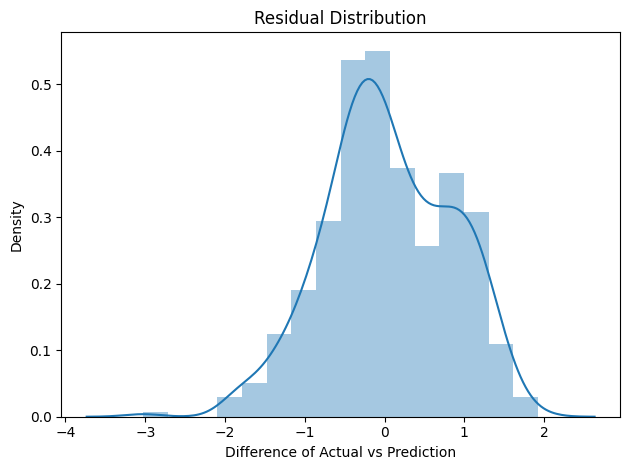

In [314]:
# @title **Step 1: Initial model** { display-mode: "form" }
# establish label (y) and features (X)
X = fill_df.iloc[:,3:13].drop(columns = ['Code'])
y = fill_df['Life Ladder']

# split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# fit the train set into the model
model = Lasso()
model.fit(X_train, y_train)

# use the model to predict the test set
yhat = model.predict(X_test)
score = r2_score(y_test, yhat)
print(f'Accuracy = {score}')
print(f'Coefficient: \n{pd.DataFrame([model.coef_], columns = X.columns).T[0]}')

# visualize the performance
sns.distplot(y_test - yhat)
plt.title('Residual Distribution')
plt.xlabel('Difference of Actual vs Prediction')

plt.tight_layout()
plt.show()

The model is doing poorly without tuning, predicting correctly for less than half of the test set, R Square is 0.52. One main reason is that, the default alpha value (penalty term) shrinks the all coefficient too hard (over-simplifying). This is very terrible and can't be used for feature selection. Now, let's try some hyper model tuning parameters to improve the model.

In [315]:
# @title **Step 2: Hyperparameter Tuning** { display-mode: "form" }
# add the scaler to deal with different scaling features
scaler = StandardScaler()
scaler.fit(X)
X_scale = scaler.fit_transform(X)

# define cross-validation parameter
cv = RepeatedKFold(
    n_splits = 10,
    n_repeats = 3,
    random_state = 1
)

# split the scaled data
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size = 0.2, random_state = 1)

# add gridsearch parameter
param = {
    'alpha':[0.00001, 0.0001,0.001, 0.01],
    'fit_intercept':[True, False],
    'positive':[True, False],
    'selection':['cyclic', 'random']
}

# define the new model
model = Lasso()

# define grid search parameter
search = GridSearchCV(
    model,
    param,
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1,
    cv = cv
)

# execute search
result = search.fit(X_scale, y)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -0.41114165941252684
Best Hyperparameters: {'alpha': 1e-05, 'fit_intercept': True, 'positive': False, 'selection': 'random'}


   Model      R2     MSE     MAE
0  LASSO  0.7926  0.2776  0.4052


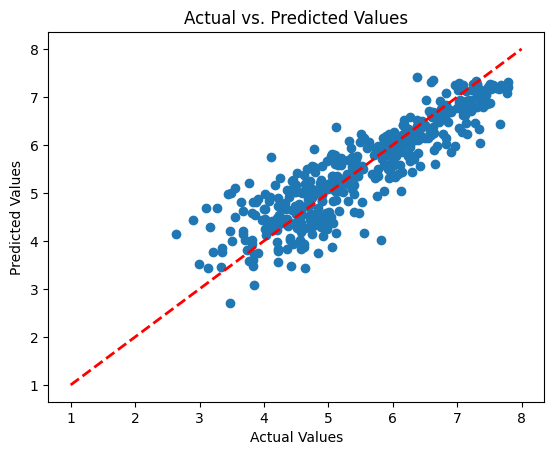

In [316]:
# @title **Step 3: Tuned Model** { display-mode: "form" }
# define the final model
model = Lasso(
    alpha = 1e-05,
    fit_intercept = True,
    positive = False,
    selection = 'cyclic'
)

# fit the new model to the train set
model.fit(X_train, y_train)

# make prediction on test set
yhat = model.predict(X_test)

# calculate the model performance
r2_lasso = round(r2_score(y_test, yhat),4)
mse_lasso = round(mean_squared_error(y_test, yhat),4)
mae_lasso = round(mean_absolute_error(y_test, yhat),4)

print(
    pd.DataFrame(
        {'Model': 'LASSO','R2': [r2_lasso],
        'MSE': [mse_lasso], 'MAE': [mae_lasso]}
    )
)

# visualization of the new model
plt.scatter(y_test, yhat)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference
plt.plot(
    [1,8],
    [1,8],
    linestyle = '--',
    color = 'red',
    linewidth = 2
)

plt.show()

Now after the hyper training, we can see that model perform much better than before, with R Square equal to 0.79 and low Mean Square Error (MSE) and Mean Absolute Error (MAE) of 0.27 and 0.40 respectively.

In [317]:
# @title **Step 4: Feature Selection** { display-mode: "form" }
# check selected feature if threshold is coefficient = 0
selected_features = X.columns[abs(model.coef_) >= 0.1]
print(f'Coefficient: \n{pd.DataFrame([model.coef_], columns = X.columns).T[0]}\n')

# print selected features
for i in selected_features:
    print(f"Feature selected is: {i}")

Coefficient: 
Log GDP per capita                  0.413136
Social support                      0.234081
Healthy life expectancy at birth    0.207954
Freedom to make life choices        0.051529
Generosity                          0.055762
Perceptions of corruption          -0.117366
Positive affect                     0.246976
Negative affect                    -0.023542
Median age                          0.007204
Name: 0, dtype: float64

Feature selected is: Log GDP per capita
Feature selected is: Social support
Feature selected is: Healthy life expectancy at birth
Feature selected is: Perceptions of corruption
Feature selected is: Positive affect


Now we have simplified the model from 9 features to only 5 features. We can use this simplified version to build the predicting model for the happiness score.

### **4.3. Models training and prediction**

In this section, I will fit the selected features to 2 machine learning algorithm to predict the label, `Life Ladder`, as following:
- K-Nearest Neighbour (KNN): will predict the `Life Ladder` as continuous value. 0 being the worst life satisfaction and 10 being the most ideal life satisfaction.

- Decision Tree: will predict the `Life Ladder` as categorical value. For model simplicity, we will label value in range of '0-3' as 'Not ideal', '3-6.5' as 'Moderate', '6.5+' as 'Ideal'.`

### **i. K-Nearest Neighbour (KNN)**

KNN is a simple yet effective machine learning algorithm that support regression tasks (when outcome variable is continuous value). This model is used to predict the value of a data point based on the majority average of its k nearest neighbors in the feature space. Simply, it works under the assumption that neighbour data points are likely to generate similar outcome (label variable). There are various benefits to use this methods such as non-parametric required, versatile, and very simple model that can be built on later. Below is an illustration and theoretical visualization of how the algorithm works.

*Image source: Google Image*

<img src="https://th.bing.com/th/id/OIP.Y4Spr7_dUTzlnmwmmyzecAHaEs?rs=1&pid=ImgDetMain" alt="Drawing" style="width:256px;height:16px">

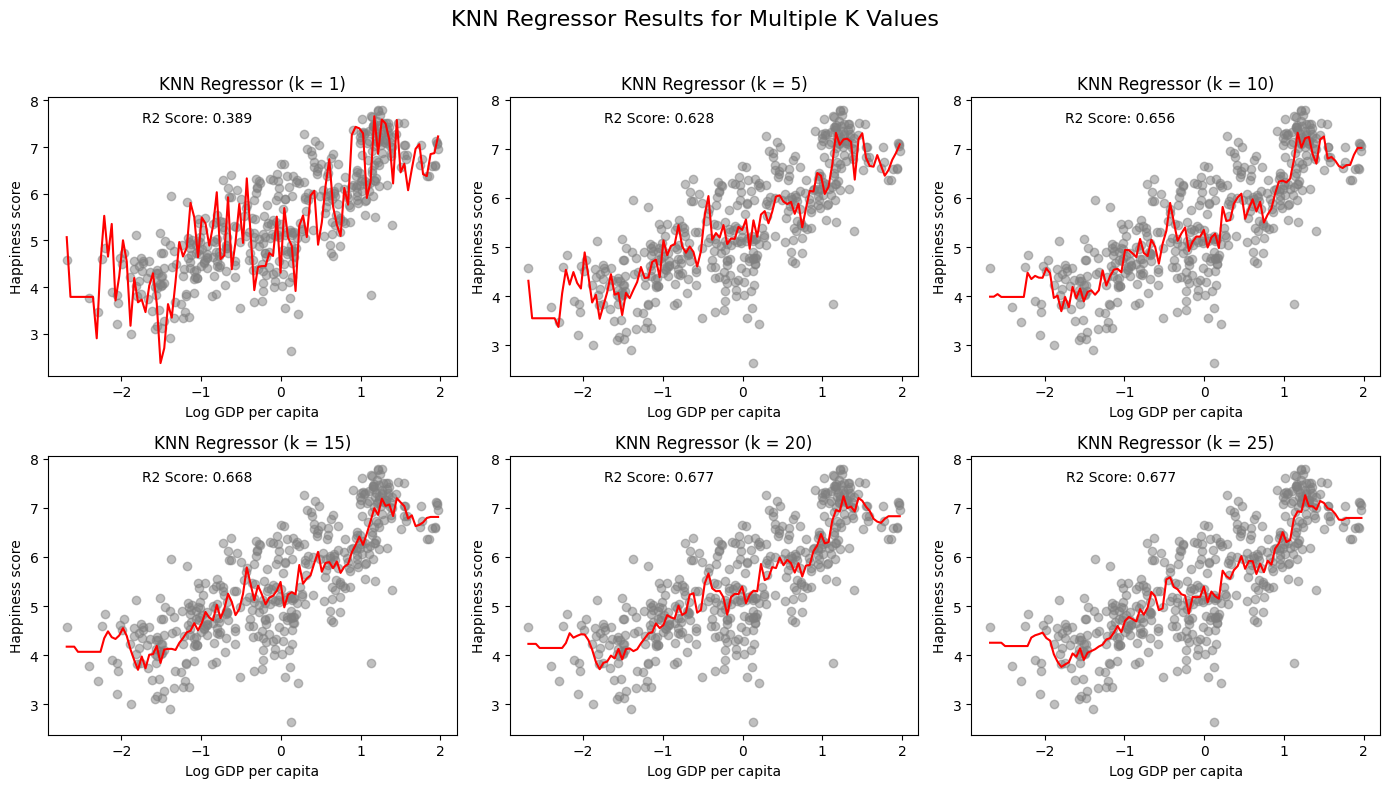

In [318]:
# @title **Step 1: Initial KNN model** { display-mode: "form" }
# define the new features (X)
sel_X_train = pd.DataFrame(X_train, columns = X.columns)[selected_features]
sel_X_test  = pd.DataFrame(X_test, columns = X.columns)[selected_features]

# Values of k to iterate over
k_values = [1, 5, 10, 15, 20, 25]
array_X_train = np.array(sel_X_train)
array_X_test = np.array(sel_X_test)
feature_to_visualize = 0

# Create a 2x3 subplot layout
fig, axes = plt.subplots(2, 3, figsize =(14, 8))

# Iterate over k values and plot predictions for the chosen feature
for k, ax in zip(k_values, axes.flatten()):
    # Fit k-NN regressor
    knn_reg = KNeighborsRegressor(n_neighbors = k)
    knn_reg.fit(array_X_train[:, feature_to_visualize].reshape(-1, 1), y_train)

    # Predictions on test set
    y_pred = knn_reg.predict(array_X_test[:, feature_to_visualize].reshape(-1, 1))

    # Plot the true values and predictions for the chosen feature
    ax.scatter(array_X_test[:, feature_to_visualize], y_test, color='gray', alpha = 0.5)
    # ax.scatter(array_X_test[:, feature_to_visualize], y_pred, color='red', alpha = 0.5)

    # Plot the best fit line
    x_range = np.linspace(array_X_test[:, feature_to_visualize].min(), array_X_test[:, feature_to_visualize].max(), 100)
    y_range = knn_reg.predict(x_range.reshape(-1, 1))
    ax.plot(x_range, y_range, color='red')

    # Calculate and display R2 score
    r2 = r2_score(y_test, y_pred)
    ax.text(0.5, 0.9, f'R2 Score: {r2:.3f}', transform=ax.transAxes, ha='right', va='bottom')

    # Set labels and title
    ax.set_xlabel('Log GDP per capita')
    ax.set_ylabel('Happiness score')
    ax.set_title(f'KNN Regressor (k = {k})')

# Adjust layout
plt.suptitle('KNN Regressor Results for Multiple K Values', fontsize = 16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [321]:
# @title **Step 2: Hyperparameter Tuning** { display-mode: "form" }
# define the parameter
grid_params = {
    'n_neighbors' : list(range(1, 26)),
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']
}

# define grid search parameter
search = GridSearchCV(
    KNeighborsRegressor(),
    grid_params,
    verbose = 1,
    cv = 5,
    n_jobs = -1
)

# fit the training model
result = search.fit(sel_X_train, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best Score: 0.8377706816701649
Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}


  Model      R2     MSE     MAE
0   KNN  0.8615  0.1853  0.3139


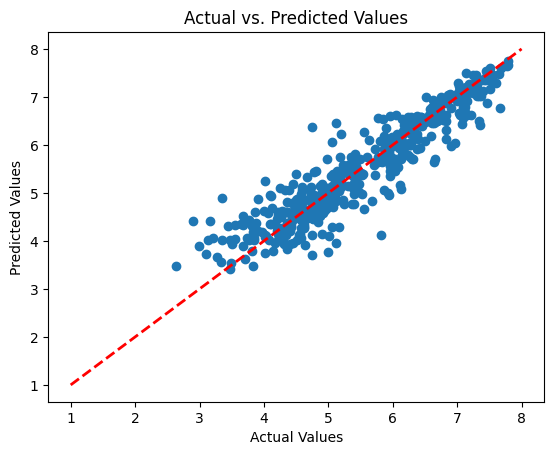

In [322]:
# @title **Step 3: Tuned Model** { display-mode: "form" }
# define the new model
knn = KNeighborsRegressor(
    n_neighbors = 7,
    weights = 'distance',
    metric = 'manhattan',
    algorithm = 'brute'
)

# fit the training set to the model
knn.fit(sel_X_train, y_train)

# predict the test set using trained model
yhat = knn.predict(sel_X_test)

# calculate the model performance
r2_knn = round(r2_score(y_test, yhat), 4)
mse_knn = round(mean_squared_error(y_test, yhat), 4)
mae_knn = round(mean_absolute_error(y_test, yhat), 4)

print(pd.DataFrame(
    {'Model': 'KNN',
     'R2': [r2_knn],
     'MSE': [mse_knn],
     'MAE': [mae_knn]}
    )
)

# visualization of the new model
plt.scatter(y_test, yhat)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference
plt.plot(
    [1,8],
    [1,8],
    linestyle = '--',
    color = 'red',
    linewidth = 2)

plt.show()

R2 = 0.8949


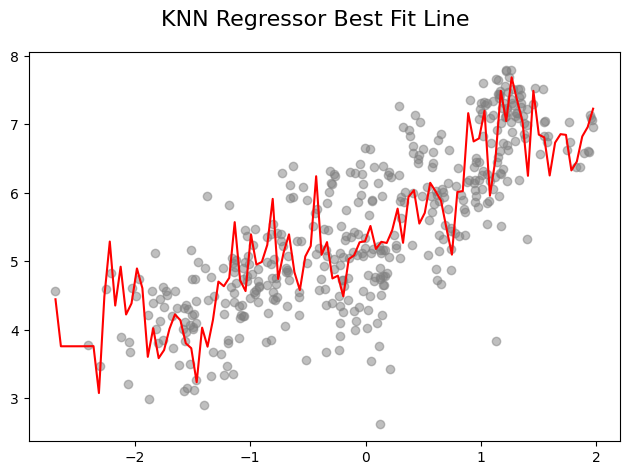

In [295]:
# @title **Step 4: Final best fit line** { display-mode: "form" }
# fit just 1 feature to the model
knn.fit(array_X_train[:, feature_to_visualize].reshape(-1, 1), y_train)

# make prediction
y_pred = knn.predict(array_X_test[:, feature_to_visualize].reshape(-1, 1))

# plot the final data
plt.scatter(array_X_test[:, feature_to_visualize], y_test, color = 'gray', alpha = 0.5)

# plot the best fit line
x_range = np.linspace(array_X_test[:, feature_to_visualize].min(), array_X_test[:, feature_to_visualize].max(), 100)
y_range = knn.predict(x_range.reshape(-1, 1))
plt.plot(x_range, y_range, color = 'red')

# Adjust layout
print(f'R2 = {r2_knn}')
plt.suptitle('KNN Regressor Best Fit Line', fontsize = 16)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

In [324]:
# @title **Step 5: Prediction for whole dataset** { display-mode: "form" }
# re-train the model
knn = KNeighborsRegressor(
    n_neighbors = 4,
    weights = 'distance',
    metric = 'manhattan',
    algorithm = 'brute'
)

# fit the training set to the model
knn.fit(sel_X_train, y_train)

# establish label and features
features = pd.DataFrame(X_scale, columns = X.columns)[selected_features]
yhat_knn = pd.DataFrame(knn.predict(features), columns = ['Prediction'])

# merge the prediction to actual dataset
label = fill_df[['Year', 'Life Ladder']]

knn_df = pd.merge(
    label,
    yhat_knn,
    left_index = True,
    right_index = True
)

df_avg = knn_df.groupby('Year').mean().reset_index()

# set up the plot area and label
fig = px.line(
    df_avg,
    x = 'Year',
    y = ['Life Ladder', 'Prediction'],
    title = 'Actual vs Predicted Happiness Score (World Average)'
)

# add a trendline
fig.update_traces(mode = 'lines')
fig.add_trace(
    px.scatter(
        df_avg,
        x='Year',
        y='Life Ladder').data[0]
)

fig.add_trace(
    px.scatter(
        df_avg,
        x='Year',
        y='Prediction').data[0]
)

# layout customizations
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Happiness Score',
    legend_title='Legend',
    plot_bgcolor = '#f5f5f5',
    xaxis = dict(linecolor = 'black'),
    yaxis = dict(linecolor = 'black'),
    height = 700,
    width = 1100
)

fig.show()

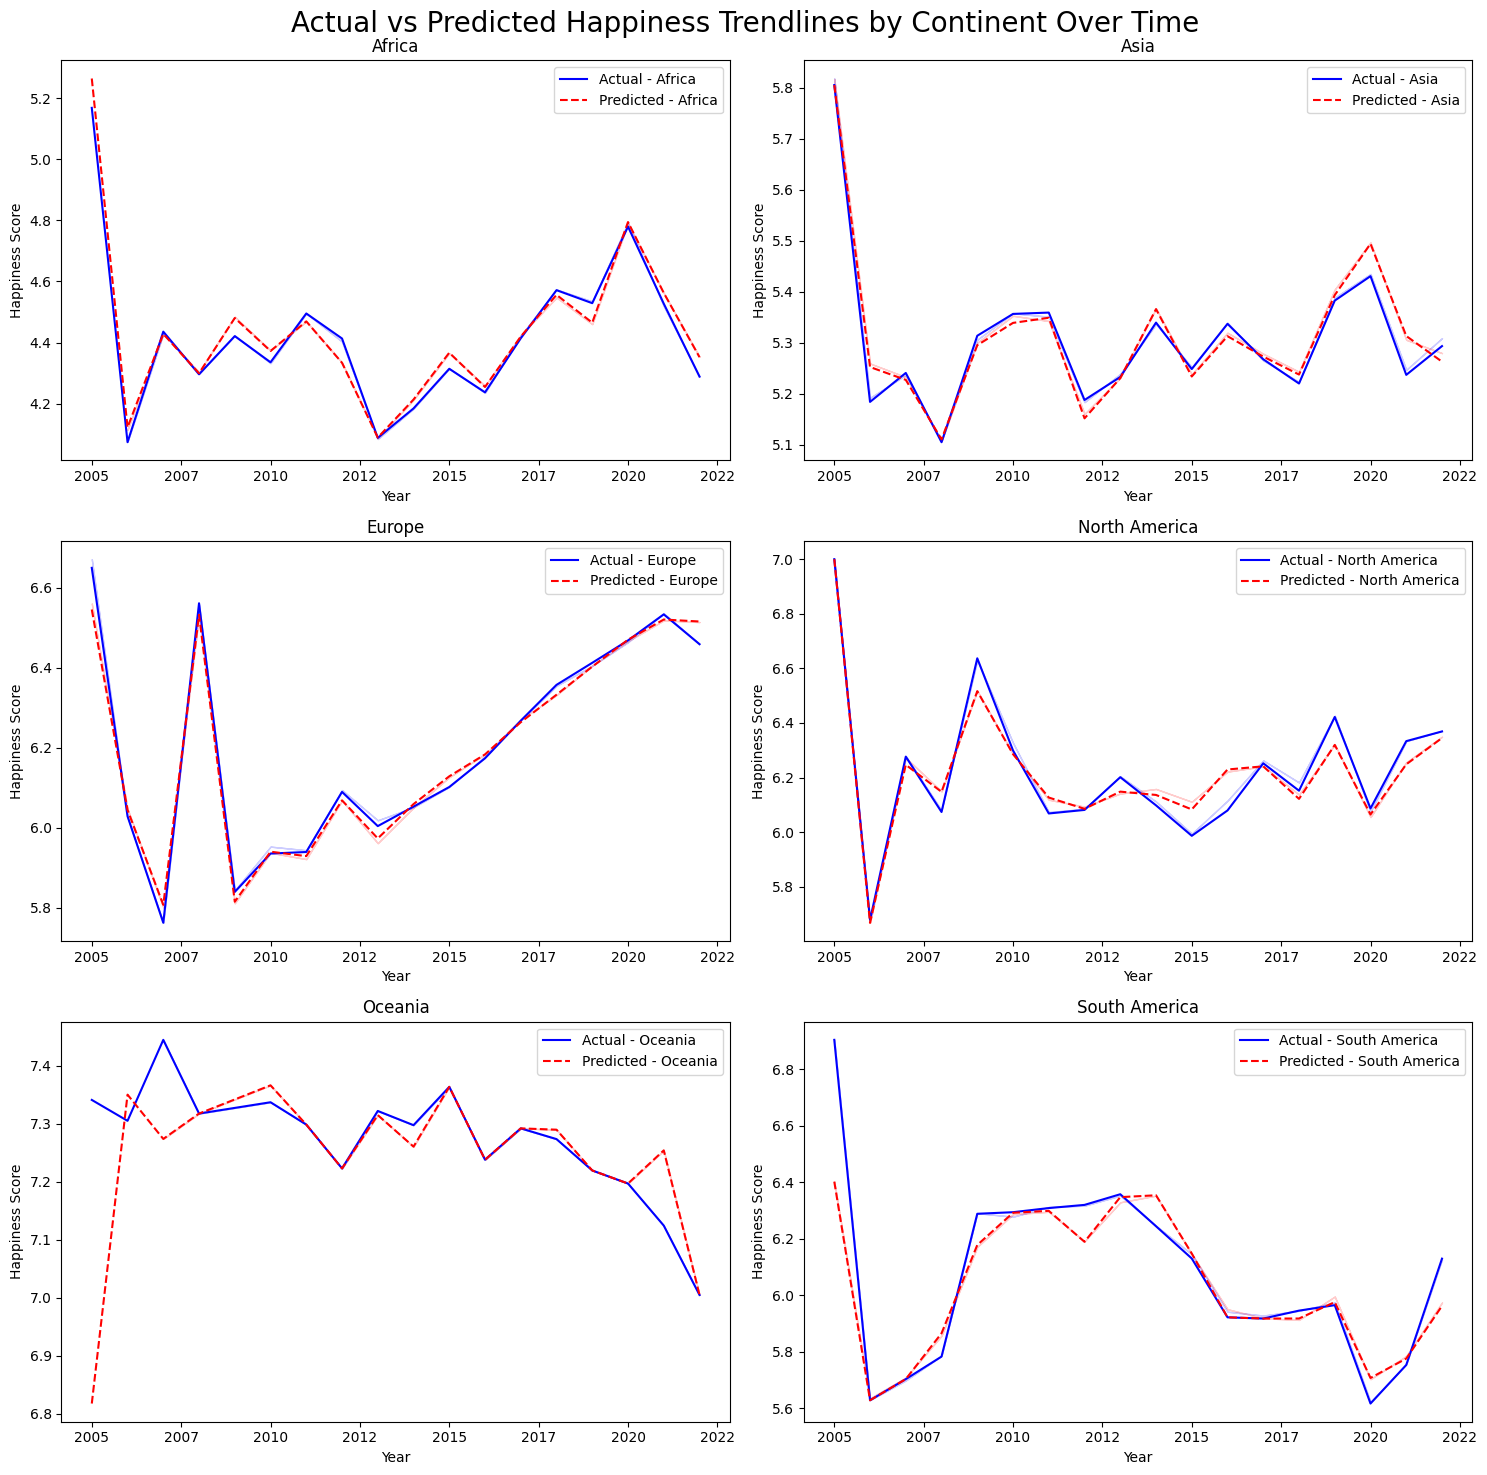

In [326]:
# @title **Step 6: Prediction for each continent** { display-mode: "form" }
# merge the prediction to actual dataset
label = fill_df[['Country', 'Continent', 'Year', 'Life Ladder']]
knn_df = pd.merge(label, yhat_knn, left_index = True, right_index = True)

# create a 3x2 grid of subplots
fig, axs = plt.subplots(3, 2, figsize = (15, 15))
fig.suptitle('Actual vs Predicted Happiness Trendlines by Continent Over Time',
            fontsize = 20)

# iterate through continents and create a line plot for each subplot
for i, (continent, group) in enumerate(knn_df.groupby('Continent')):
    row, col = divmod(i, 2)
    ax = axs[row, col]

    sns.lineplot(
        x = 'Year',
        y = 'Life Ladder',
        ci = False,
        color = 'blue',
        data = group,
        ax = ax,
        label = f'Actual - {continent}'
    )

    sns.lineplot(
        x = 'Year',
        y = 'Prediction',
        ci = False,
        color = 'red',
        data = group,
        ax = ax,
        label = f'Predicted - {continent}',
        linestyle = '--'
    )

    ax.set_title(continent)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    ax.set_xlabel('Year')
    ax.set_ylabel('Happiness Score')

# add some customizations
plt.tight_layout(rect = [0, 0, 1, 1])
plt.show()

### **ii. Decision Tree**

Decision Tree classifier is an algorithm where the data points are splited based on features to create a tree-like structure, and each leaf (the final box) represents the final decision or prediction. Intuitively, it mimics a series of "if-else" questions, making decisions based on the input features. Decision Tree is super easy to interpret and explain as well as visualization. Moreover, this model isn't affected by different scaling and outliers, making it a suitable choice for happiness score classification. We can illustrate this algorithm as human-like thought process.

*Image source: Himani, 2022*

<img src="https://www.section.io/engineering-education/hyperparmeter-tuning/tree-one.png" alt="Drawing" style="width:256px;height:16px">

Prediction Accuracy for train set: 1.0
Prediction Accuracy for test set: 0.8954545454545455


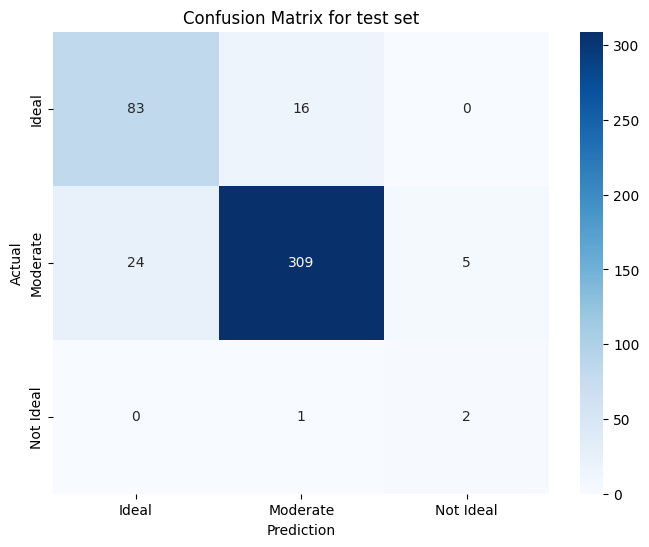

In [328]:
# @title **Step 1: Initial Decision Tree Model** { display-mode: "form" }
# label Life Ladder to categorical values
label_df = fill_df.sort_index()

bins = [0, 3, 6.5, 10]
labels = ['Not Ideal', 'Moderate', 'Ideal']

label_df['Category'] = pd.cut(
    label_df['Life Ladder'],
    bins = bins,
    labels = labels
)

# drop unneccessary columns for model training
X_tree = label_df[selected_features]
y_tree = label_df.iloc[:,[-1]]

# split the data into train and test set
X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(
    X_tree, y_tree,
    test_size = 0.2,
    random_state = 1
)

# define the model and fit the train set
dtree = DecisionTreeClassifier()
dtree.fit(X_tree_train, y_tree_train)

# predict the happiness category
yhat_train = dtree.predict(X_tree_train)
yhat_test = dtree.predict(X_tree_test)

# calculate the model performance
print(f'Prediction Accuracy for train set: {accuracy_score(y_tree_train, yhat_train)}')
print(f'Prediction Accuracy for test set: {accuracy_score(y_tree_test, yhat_test)}')

# prepare the datafrme for visualization
conf_matrix = confusion_matrix(y_tree_test, yhat_test)
unique_labels = sorted(label_df['Category'].unique())
class_names = {
    label: name for label,
    name in zip(
        unique_labels,
        unique_labels
    )
}

conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index = unique_labels,
    columns = unique_labels
)

conf_matrix_df.rename(
    index = class_names,
    columns = class_names,
    inplace = True
)

# visualize confusion matrix with a heatmap
plt.figure(figsize = (8, 6))
sns.heatmap(
    conf_matrix_df,
    annot = True,
    fmt = 'd',
    cmap = 'Blues'
)

plt.title('Confusion Matrix for test set')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

The model without any hypertuning has accuracy of 1 for train set, which could mean there is overfitting and the model became too complicated. This is reflected when I try the model on the test set, the accuracy rate drop by almost 20%. Let's try hyperparameter tuning to reduce complexity and prevent overfitting.

In [330]:
# @title **Step 2: Hyperparameter Tuning**  { display-mode: "form" }
# redefine the model
dtree = DecisionTreeClassifier()

# define parameter for gridsearch
params = {
    'max_depth': list(range(2, 21)),
    'min_samples_leaf': list(range(2, 21)),
    'criterion': ["gini", "entropy"]
}

# start the grid search
grid_search = GridSearchCV(
    estimator = dtree,
    param_grid = params,
    cv = 4,
    n_jobs = -1,
    verbose = 1,
    scoring = "accuracy"
)

# fit the train data to grid search
result = grid_search.fit(X_tree_train, y_tree_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 4 folds for each of 722 candidates, totalling 2888 fits
Best Score: 0.9204208945951543
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 2}


In [331]:
# @title **Step 3: Tuned Model** { display-mode: "form" }
# define the new model
dtree = DecisionTreeClassifier(
    criterion = 'gini',
    max_depth = 8,
    min_samples_leaf = 2
)

# fit the train model
dtree.fit(X_tree_train, y_tree_train)

# make prediction on the test set
yhat_tree = dtree.predict(X_tree_test)
r2_tree = round(accuracy_score(y_tree_test, yhat_tree),4)
print(f'Prediction Accuracy for test set: {r2_tree}')

Prediction Accuracy for test set: 0.9068


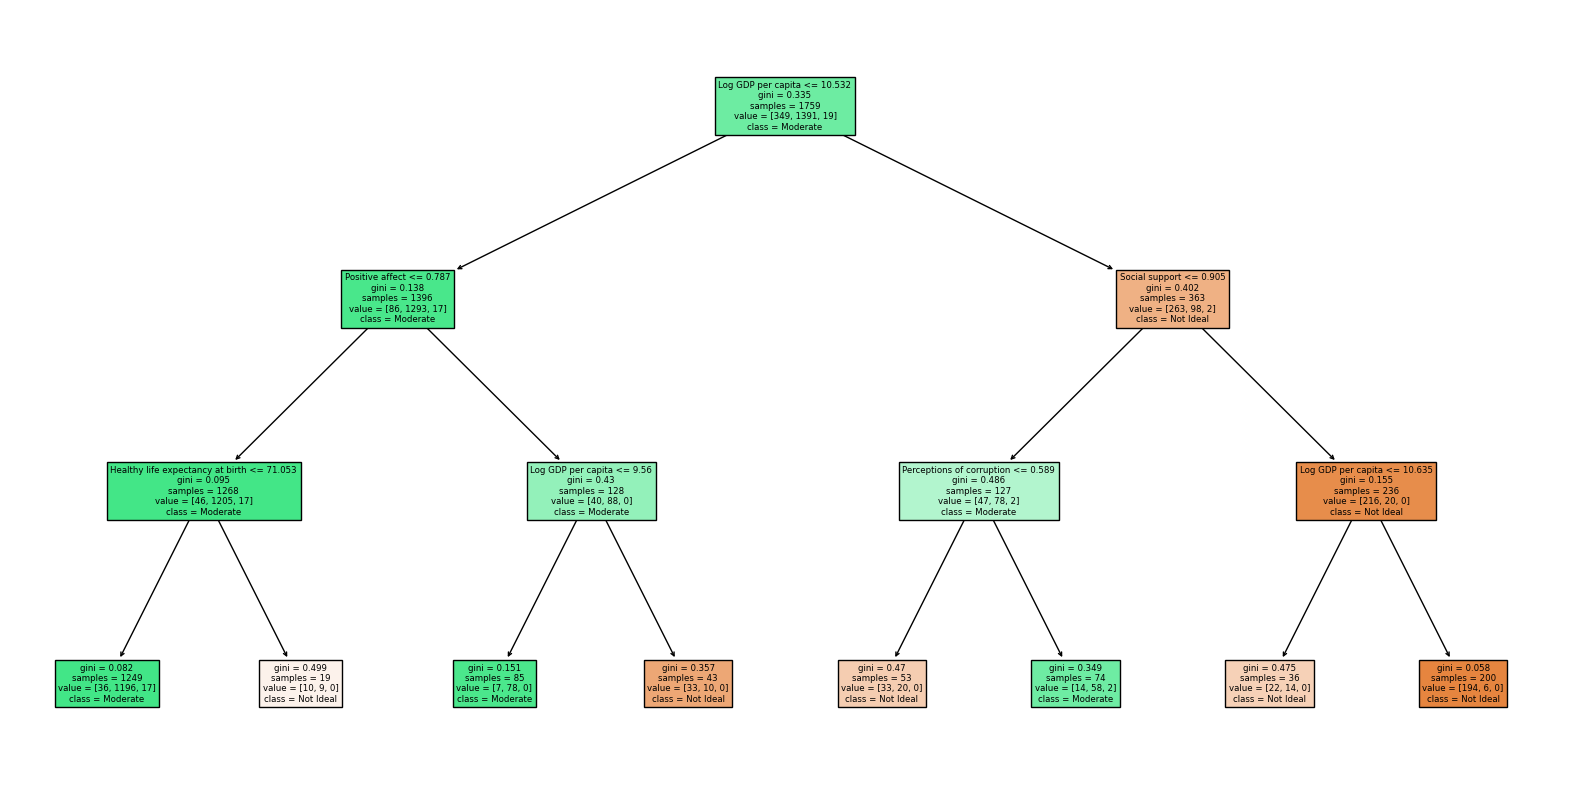

In [332]:
# @title **Step 4: Visualize the tree** { display-mode: "form" }
# build a 3 depth decision tree (5 depth is hard to illustrate)
# define the new model
tree_plot = DecisionTreeClassifier(
    criterion = 'gini',
    max_depth = 3,
    min_samples_leaf = 2
)

# fit the train model
tree_plot.fit(X_tree_train, y_tree_train)

fig = plt.figure(figsize = (20, 10))
_ = tree.plot_tree(
    tree_plot,
    feature_names = list(X_tree.columns),
    class_names = labels,
    filled = True
)

**Step 6:** fit the whole dataset

The prediction score for whole dataset: 0.9536152796725784.


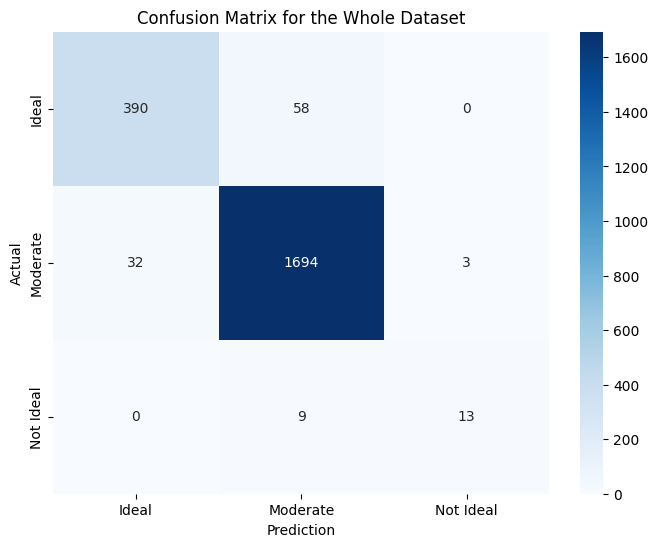

In [333]:
# @title **Step 5: Prediction** { display-mode: "form" }
# make the prediction on whole dataset
yhat_tree = dtree.predict(X_tree)

# make confusion table
conf_matrix = confusion_matrix(y_tree, yhat_tree)

conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index = unique_labels,
    columns = unique_labels
)

conf_matrix_df.rename(
    index = class_names,
    columns = class_names,
    inplace = True
)

# print prediction score
tree_score = accuracy_score(y_tree, yhat_tree)
print(f'The prediction score for whole dataset: {tree_score}.')

# visualize the confusion table
plt.figure(figsize = (8, 6))
sns.heatmap(
    conf_matrix_df,
    annot = True,
    fmt = 'd',
    cmap = 'Blues'
)

plt.title('Confusion Matrix for the Whole Dataset')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

The model seem to be stable for the train set, test set, and whole dataset as the accuracy doesn't significantly change when the different values of features being fit into.

## **5. Conclusion**

After data cleaning, preprocessing, and analysis, in this section, I will conclude the study by answering the 2 research questions based on the trained model.

In [340]:
# @title **Step 1: Model Score** { display-mode: "form" }
# summary of the model trained and prediction performance
result_dict = {
    'Model': ['LASSO', 'KNN Regressor', 'Decision Tree'],
    'R Squred': [r2_lasso, r2_knn, r2_tree]
}

result_df = pd.DataFrame(result_dict)

# selected features
print('1. What are the important features that can be used to predict happiness or SWB of countries around the world?')
print(f'\nThe important features according to LASSO are:\n {pd.DataFrame(selected_features)[0]}\n')

# model accuracy
print('2. What is the accuracy for machine learning model to predict the happiness or SWB using only important features?')
result_df

1. What are the important features that can be used to predict happiness or SWB of countries around the world?

The important features according to LASSO are:
 0                  Log GDP per capita
1                      Social support
2    Healthy life expectancy at birth
3           Perceptions of corruption
4                     Positive affect
Name: 0, dtype: object

2. What is the accuracy for machine learning model to predict the happiness or SWB using only important features?


,Model,R Squred
0,LASSO,0.7926
1,KNN Regressor,0.8615
2,Decision Tree,0.9068


In this study, I deploy machine learning approaches to World Happiness Report 2023 dataset in an attempt to predict the happiness (SWB) score of countries around world. Using LASSO approach, I was able to reduce some weak predictors pre-determined by WHR 2023. Based on this study, the important predictors are GDP per capita, Social support, Healthy life expectancy at birth, Perceptions of corruption, and Positive affect. Using the remaining features, I trained 1 regression model (KNN) and 1 classifier model (Decision Tree). The regression model KNN able to make prediction with precision of 86%. This model is suitable to make prediction of happiness score from a scale of 0-10 to decimals precision. On the other hand, classifier 'Decision Tree' can make prediction more than 90% precision. This model is suitable to make prediction on happiness categories such as ideal, moderate, and not ideal happiness.

In [39]:
# @title **Step 2: Happiness Predictor Prototype** { form-width: "1px", display-mode: "form" }
GDP_per_capita = 50000 # @param {type:"number"}
Social_support = 60.97 # @param {type:"number"}
Life_expectancy = 59.23 # @param {type:"number"}
Corruption = 45.89 # @param {type:"number"}
Positive_feeling = 60.02 # @param {type:"number"}

model_map = {'knn': knn, 'decision tree': dtree}
model = "decision tree" # @param {type:"string"}
model = model.lower()
selected_model = model_map.get(model)

feature = [
    math.log(GDP_per_capita),
    Social_support,
    Life_expectancy,
    Corruption,
    Positive_feeling
]

if model == 'knn':
  selected_X = X[selected_features]
  scaler = StandardScaler()
  scaler.fit(selected_X)
  scale_feature = scaler.transform([feature])
  result = knn.predict(scale_feature)[0]
  print(f"Your happiness score is: {round(result,3)}")
else:
  result = make_prediction(selected_model, feature)
  print(f"Your happiness category is: {result.upper()}")


Your happiness category is: IDEAL


## **6. References**


1. Helliwell, J. F., Layard, R., Sachs, J. D., Aknin, L. B., De Neve, J.-E., & Wang, S. (Eds.). (2023). World Happiness Report 2023 (11th ed.). Sustainable Development Solutions Network.

2. Median age. Our World in Data. (n.d.). https://ourworldindata.org/grapher/median-age

